In [156]:
!pip install wandb

In [157]:
!wandb login

Traceback (most recent call last):
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jvent\Documents\Anaconda\envs\pytorch\Scripts\wandb.exe\__main__.py", line 7, in <module>
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\site-packages\click\core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\site-packages\click\core.py", line 782, in main
    rv = self.invoke(ctx)
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\site-packages\click\core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "c:\users\jvent\documents\anaconda\envs\pytorch\lib\site-packages\click\core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.para

In [158]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [159]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar')

In [7]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader_vae as dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import os
import sys
import time
from collections import OrderedDict
import random

import wandb


In [8]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model



def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

#### Variational AE.

In [9]:
import torch
from models import AdaptiveVAE
import dataloader_vae as dataloader
from torchvision import datasets, transforms


# Hyper Parameter settings
img = 64
crop = 0
hid_size = 64
ker = 3
strides = (2, 2, 2, 2)
leaky = (1, 1)

# Networks setup
print('\nModel setup')
print('| Building network: AdaptiveVAE(hid_size=%s)' % hid_size)
print('| Input image size: %s' % img)
vae_net = AdaptiveVAE(img=img, hid_size=hid_size, ker=ker, strides=strides, leaky=leaky)

checkpoint_vae = torch.load(config.drive_dir + '/checkpoint/VAE_h%s.pth.tar' % hid_size,
                            map_location='cpu')
vae_net.load_state_dict(checkpoint_vae['state_dict'])




Model setup
| Building network: AdaptiveVAE(hid_size=64)
| Input image size: 64


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
# Get the original_dataset
loader = dataloader.KeyDataLoader()
loader.add_transform(
    transforms.Compose([
        transforms.Resize(img + crop),
        transforms.CenterCrop(img),
        transforms.ToTensor(),
    ]))
train_loader, valid_loader, test_loader = loader.run()

In [4]:
(inputs, inputs_vae, targets) = next(iter(train_loader))

In [6]:
inputs_vae.shape

torch.Size([128, 3, 64, 64])

In [10]:
with torch.no_grad():
    mu, logvar = vae_net.encode(inputs_vae)
    std = torch.exp(0.5 * logvar)
    rec, _, _ = vae_net(inputs_vae)

encoder_output: 1 torch.Size([128, 64, 32, 32])
encoder_output: 2 torch.Size([128, 128, 16, 16])
encoder_output: 3 torch.Size([128, 256, 8, 8])
encoder_output: 4 torch.Size([128, 512, 4, 4])
encoder_output: 1 torch.Size([128, 64, 32, 32])
encoder_output: 2 torch.Size([128, 128, 16, 16])
encoder_output: 3 torch.Size([128, 256, 8, 8])
encoder_output: 4 torch.Size([128, 512, 4, 4])
decoder_input: 5 torch.Size([128, 512, 4, 4])
decoder_input: 6 torch.Size([128, 256, 8, 8])
decoder_input: 7 torch.Size([128, 128, 16, 16])
decoder_input: 8 torch.Size([128, 64, 32, 32])


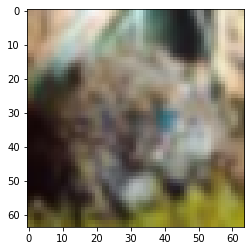

In [11]:
import matplotlib.pyplot as plt
plt.imshow(inputs_vae[1].permute(1, 2, 0))

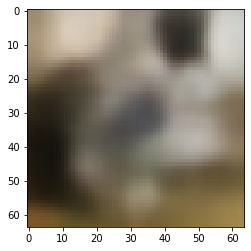

In [12]:
plt.imshow(rec[1].permute(1, 2, 0))

In [40]:
(Atargets[idx]==targets).numpy()

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

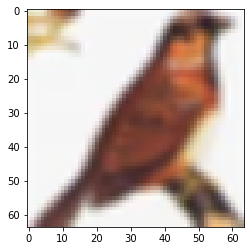

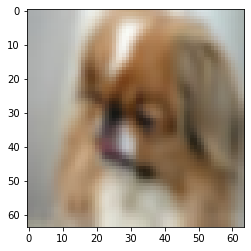

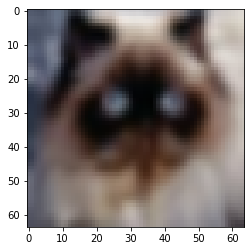

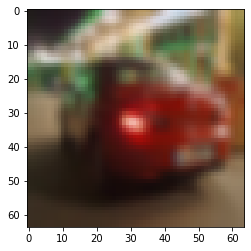

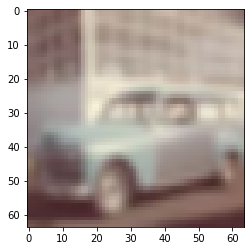

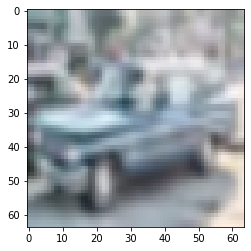

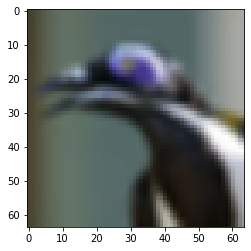

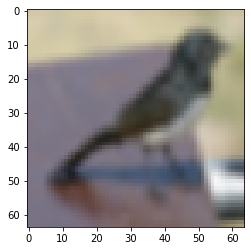

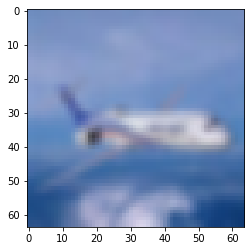

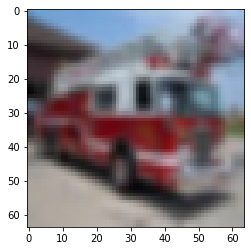

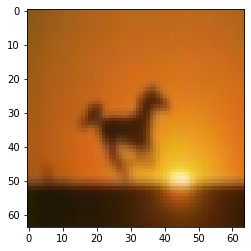

In [17]:
idx=2
std = torch.exp(0.5 * logvar)
cov = 0.5 * std[idx].add(std)
mah_dist = 1/8 * torch.sum((mu[idx] - mu) * cov * (mu[idx] - mu), 1)
_, neighbor = torch.topk(mah_dist, 10+1, largest=False)

for i in neighbor.numpy():
    plt.imshow(inputs_vae[i].permute(1, 2, 0))
    plt.show()

In [ ]:
mu.numpy()

In [ ]:
X

In [18]:
from sklearn.cluster import KMeans
import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],
#                [10, 2], [10, 4], [10, 0]])
X = mu.numpy()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
kmeans.labels_

array([3, 0, 3, 4, 8, 4, 9, 7, 1, 2, 3, 7, 7, 1, 4, 3, 6, 3, 5, 9, 4, 7,
       3, 1, 7, 2, 3, 1, 1, 0, 7, 6, 1, 6, 1, 9, 7, 9, 3, 6, 1, 1, 4, 3,
       7, 6, 1, 6, 0, 3, 1, 9, 7, 6, 6, 6, 8, 5, 1, 9, 3, 1, 9, 6, 5, 1,
       1, 1, 3, 6, 7, 3, 7, 3, 7, 1, 1, 1, 3, 7, 4, 7, 1, 1, 3, 3, 2, 3,
       3, 6, 1, 7, 1, 4, 3, 1, 8, 2, 3, 9, 1, 6, 1, 7, 7, 1, 3, 1, 3, 1,
       5, 7, 1, 3, 7, 1, 7, 7, 9, 6, 3, 6, 7, 1, 1, 6, 2, 1])

In [19]:
targets

tensor([6, 0, 5, 5, 1, 9, 6, 5, 6, 6, 1, 8, 0, 2, 0, 9, 7, 2, 1, 8, 0, 6, 5, 2,
        8, 8, 3, 9, 6, 9, 9, 0, 9, 9, 5, 1, 1, 7, 0, 2, 7, 8, 5, 9, 7, 8, 5, 1,
        9, 4, 4, 9, 0, 2, 1, 0, 7, 9, 0, 8, 2, 5, 2, 9, 4, 8, 7, 8, 9, 0, 4, 4,
        0, 7, 1, 7, 3, 4, 8, 7, 2, 6, 1, 6, 0, 3, 3, 0, 8, 1, 8, 0, 1, 7, 6, 7,
        5, 3, 7, 5, 9, 3, 4, 8, 1, 3, 0, 1, 7, 7, 1, 8, 3, 6, 0, 2, 1, 7, 1, 7,
        1, 8, 8, 1, 5, 1, 8, 8])

In [20]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(targets.numpy(), kmeans.labels_)
print("Accuracy score is", acc)

Accuracy score is 0.0859375


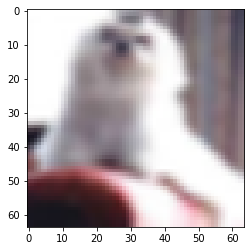

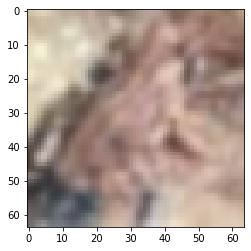

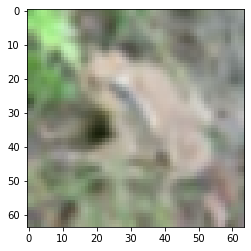

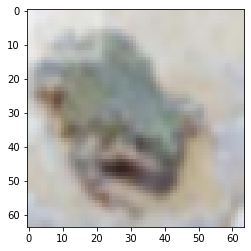

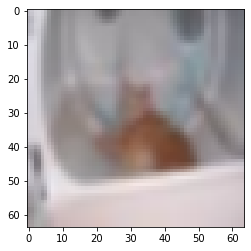

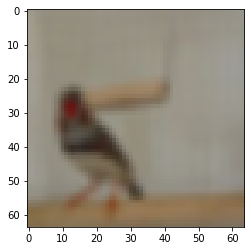

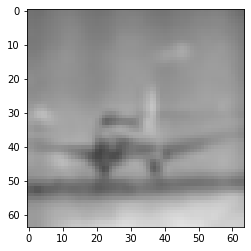

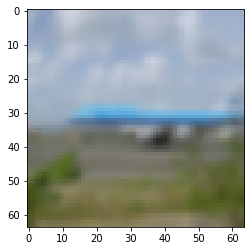

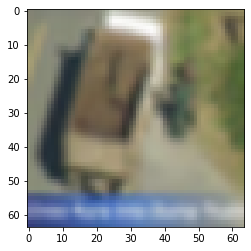

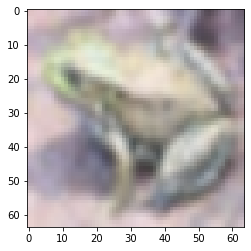

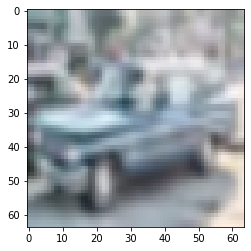

In [14]:
dist = torch.sum((mu[idx]-mu)**2, dim=1)
_, neighbor = torch.topk(dist, 10+1, largest=False)
for i in neighbor.numpy():
    plt.imshow(inputs_vae[i].permute(1, 2, 0))
    plt.show()

In [ ]:
def scheduler(epoch: int):
    global lr
    lr = config.lr
    if epoch > config.start_epoch:
        lr = lr / 10.0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training
def train(epoch):
    global init
    net.train()
    tch_net.train()
    train_loss = 0
    correct = 0
    total = 0
    scheduler(epoch)


    # ramp up meta-learning rate and EMA decay
    if epoch <= config.param_epoch:
        u = epoch/config.param_epoch
        meta_lr = config.meta_lr*math.exp(-5*(1-u)**2)
        lamb = 0.5*math.exp(-5*(1-u)**2)
    else:
        meta_lr = config.meta_lr
        config.eps = 0.999

    for step, (inputs, inputs_vae, targets) in enumerate(train_loader):
        init_time = time.time()
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)

        class_loss = criterion(outputs, targets)
        class_loss.backward(retain_graph=True)


        if step > config.start_iter or epoch > 1:
        #if step > 0 or epoch > 0:

            # if step > config.mid_iter or epoch > 1:
            #     # config.eps = 0.999
            #     alpha = config.alpha
            # else:
            #     u = (step - config.start_iter)/(config.mid_iter - config.start_iter)
            #     alpha = config.alpha*math.exp(-5*(1-u)**2)
            alpha = config.alpha

            if init:
                init = False
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.copy_(param.data)
            else:
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.mul_(config.eps).add_((1-config.eps), param.data)

            # _, feats = pretrain_net(inputs, get_feat=True)
            with torch.no_grad():
                feats, _ = vae_net.encode(inputs_vae)
                # mu, logvar = vae_net.encode(inputs_vae)
                # std = torch.exp(0.5 * logvar)
            
            tch_outputs = tch_net(inputs, get_feat=False)
            p_tch = F.softmax(tch_outputs, dim=1)
            p_tch.detach_()

            if use_mentor == True:
                mnt_outputs = mentor_net(inputs, get_feat=False)
                p_mnt = F.softmax(tch_outputs, dim=1)
                p_mnt.detach_()

            for i in range(config.num_fast):
                targets_fast = targets.clone()
                randidx = torch.randperm(targets.size(0))
                for n in range(int(targets.size(0)*config.perturb_ratio)):
                    num_neighbor = 10
                    idx = randidx[n]
                    feat = feats[idx]
                    feat.view(1, feat.size(0))
                    feat.data = feat.data.expand(targets.size(0), feat.size(0))
                    dist = torch.sum((feat-feats)**2, dim=1)
                    _, neighbor = torch.topk(dist.data, num_neighbor+1, largest=False)
                    targets_fast[idx] = targets[neighbor[random.randint(1, num_neighbor)]]

                fast_loss = criterion(outputs, targets_fast)

                grads = torch.autograd.grad(fast_loss, net.parameters(),
                                            create_graph=False,
                                            retain_graph=True,
                                            only_inputs=True)

                fast_weights = OrderedDict(
                    (name, param - meta_lr*grad)
                    for ((name, param), grad) in zip(net.named_parameters(), grads))

                fast_out = net.forward(inputs,fast_weights)

                logp_fast = F.log_softmax(fast_out,dim=1)

                #afegir canvis per iterative aquí
                if use_mentor == False:
                    consistent_loss = consistent_criterion(logp_fast, p_tch)
                else:
                    consistent_loss = consistent_criterion(logp_fast, p_tch*lamb + p_mnt*(1-lamb))

                consistent_loss = consistent_loss*alpha/config.num_fast
                consistent_loss.backward()

        optimizer.step()

        # train_loss += class_loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab training results
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%, time: %.3f'
              %(epoch, config.num_epochs, step+1, (len(train_loader.dataset)//config.batch_size)+1, class_loss.data.item(), 100.*correct/total,time.time() - init_time))
        sys.stdout.flush()



def valid(epoch, network):
    global best_acc
    network.eval()
    # val_loss = 0
    correct = 0
    total = 0
    for step, (inputs, targets) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = network(inputs)
            loss = criterion(outputs, targets)

        # valid_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab validation results
        valid_acc = 100. * correct / total
      # valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, "
      #                 "lr: {:.6f}".format(epoch,
      #                                     config.num_epochs,
      #                                     loss.data.item(),
      #                                     valid_acc,
      #                                     lr))
        # Grab validation results
        valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, ""lr: {:.6f}".format(epoch,config.num_epochs,loss.data.item(),valid_acc,lr))
        record.write(valid_results + '\n')
        record.flush()



    # Save checkpoint when best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('| Saving Best Model ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '.pth.tar'
        save_checkpoint({
            'state_dict': network.state_dict(),
            'best_acc': best_acc,
        }, save_point)

    wandb.log({'epoch': epoch, 'accy_val' : best_acc })

    return valid_results


def test():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)


In [ ]:
def save_weights(epoch):
        print('| Saving Weights student ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)

        print('| Saving Weights teacher ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': tch_net.state_dict(), }, save_point)

In [ ]:
# Checkpoint dir.
record = open(config.drive_dir + '/checkpoint/' + config.checkpoint + '_test.txt', 'w')
record.write('noise_rate=%s\n' % config.noise_rate)
record.flush()

# # Get the original_dataset
# loader = dataloader.KeyDataLoader()
# train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
tch_net = get_model()
pretrain_net = get_model()
test_net = get_model()

print('| load pretrained net. from checkpoint...')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
pretrain_net.load_state_dict(checkpoint['state_dict'])

if use_cuda:
    net.cuda()
    tch_net.cuda()
    pretrain_net.cuda()
    test_net.cuda()
    cudnn.benchmark = True
pretrain_net.eval()

for param in tch_net.parameters():
    param.requires_grad = False
for param in pretrain_net.parameters():
    param.requires_grad = False

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()
consistent_criterion = torch.nn.KLDivLoss()

# Instantiate an optimizer to train the model
optimizer = torch.optim.SGD(
    net.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print('\nTraining model')
print('| Training Epochs = ' + str(config.num_epochs))
print('| Initial Learning Rate = ' + str(config.lr))
print('| Optimizer = ' + str(config.optimizer_type))


In [ ]:
init = True
best_acc = 0
use_mentor = False
for epoch in range(1, 1 + config.num_epochs):
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)


In [ ]:
print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()


In [ ]:
#This code is useful when the code has crashed without getting to the maximum of epochs (due to google collab session termination)
#essentially we reload weights and following continue the training process

EPOCH = 104 #Input the last epoch computed

print('Load Student')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(EPOCH) + '.pth.tar' )
net.load_state_dict(checkpoint['state_dict'])

print('Load Teacher')

checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(EPOCH) + '.pth.tar' )
tch_net.load_state_dict(checkpoint['state_dict'])

In [ ]:
init = False
best_acc = 0
for epoch in range(EPOCH, 1 + config.num_epochs):
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)

print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()

In [ ]:
# DISCARDING SAMPLES

In [ ]:
# RELOAD NETWORKS
EPOCH = 120 #Input the last epoch computed

print('Load Student')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(EPOCH) + '.pth.tar' )
net.load_state_dict(checkpoint['state_dict'])

print('Load Teacher')

checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(EPOCH) + '.pth.tar' )
tch_net.load_state_dict(checkpoint['state_dict'])

print('\nLoad Test')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])

In [ ]:
import pandas
def get_confidence_training(dataloader):
  correct = 0
  total = 0

  target_list = []
  pred        = []
  confidence  = []

  for batch_idx, (inputs, targets) in enumerate(dataloader):
      if use_cuda:
          inputs, targets = inputs.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = test_net(inputs)
          loss = criterion(outputs, targets)  
          _, predicted = torch.max(outputs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(targets.data).cpu().sum()
          
          conf = float(torch.max(outputs.softmax(dim = 1)))
          targ = int(targets.data)
          pd = int(predicted)

          confidence.append(conf)
          target_list.append(targ)
          pred.append(pd)

  # Grab dataframe
  df = pandas.DataFrame()
  df["target_list"] = target_list
  df["pred"] = pred
  df["confidence"] = confidence

  return(df)

In [ ]:
#Those parameters are key for discarding
pre_batch = config.batch_size
config.batch_size = 1
config.shuffle = False

# Get the dataloader with no shuffle
loader = dataloader.KeyDataLoader()
train_noshuffle_loader, _, _ = loader.run()


df = get_confidence_training(train_noshuffle_loader)

#get list of directories
train_df = pandas.read_csv(config.data_dir+config.train_dir, header=None)
train_df.columns = ["dir"]

#Merge directories with confidence
DF = df.merge(train_df,how = 'left', left_index = True, right_index = True)

#filter only training samples that have a high enough confidence by the softmax
tau = 0.01
df_filtered = DF[DF.confidence > tau]
df_filtered

#Export the filtered train dataset
df_filtered.to_csv(config.data_dir +'clean_train_key_list_iter2' + config.id + '.txt', header = None, index=False)
config.train_dir = 'clean_train_key_list_iter2' + config.id + '.txt'

#Reset shuffling for next iteration
config.shuffle = True
config.batch_size = pre_batch

# Get the filtered dataset
loader = dataloader.KeyDataLoader()
train_loader, _, _ = loader.run()

#Initialize mentor
mentor_net = get_model()
if use_cuda:
    mentor_net.cuda()

#Get the weights for the mentor
print('\nLoad Mentor')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
mentor_net.load_state_dict(checkpoint['state_dict'])

#set mentor parameter on the train funciton
use_mentor = True